# Asennusmäärän ennustaminen

Tehdään malli, jonka opetusaineisto otetaan vuosilta 1998-2010, syöte vuosilta 2011-2012 ja pyritään ennustamaan vuodet 2013-2019. Käytetään jälleen kuukausittaisia asennusmääriä.

## Kirjastot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import importlib.util
import sys
file_path = "../../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)


## Esikäsittelijän ajaminen

In [2]:
cols = ['installation_date']
df_all = esik.esik(cols)


## Luodaan aikasarja

Aikasarjan indeksinä on kuukausi ja arvona kaikkien kyseisen kuukauden aikana tehtyjen asennusten määrä.

In [3]:
df = df_all.copy()
df['year-month'] = df['installation_date'].dt.strftime('%Y-%m')


In [4]:
value_counts_df = df['year-month'].value_counts().sort_index()
value_counts_df = pd.DataFrame({'year-month': value_counts_df.index, 'count': value_counts_df})
month_period = pd.period_range(start='1998-01-01', end='2019-12-01', freq='M').strftime('%Y-%m')
month = pd.DataFrame(data=month_period, columns=['year-month'], dtype='object')
merged = month.merge(value_counts_df, how='left', on='year-month')
df_year_month = merged.fillna(0)
df_year_month.index = month_period
display(df_year_month)


year-month    count
1998-01    1998-01      1.0
1998-02    1998-02      1.0
1998-03    1998-03      0.0
1998-04    1998-04      1.0
1998-05    1998-05      2.0
...            ...      ...
2019-08    2019-08  13816.0
2019-09    2019-09  13286.0
2019-10    2019-10  13239.0
2019-11    2019-11  13587.0
2019-12    2019-12  15062.0

[264 rows x 2 columns]

## Muokataan ja valitaan data mallia varten

Tehdään valinta käytetäänkö ennustuksessa eksponentiaalisesti painotettua keskiarvoa, liukuvaa keskiarvoa vai asennusmääriä sellaisenaan.

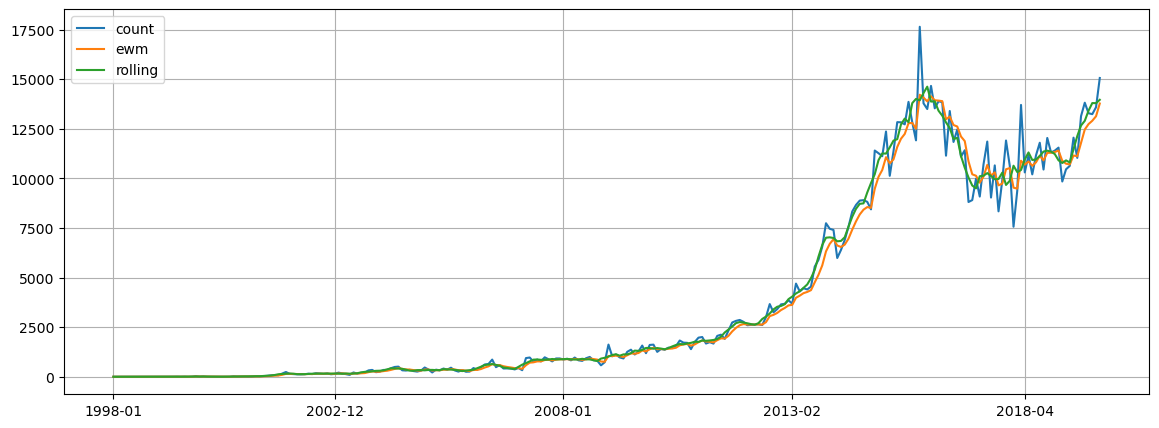

In [5]:
df = df_year_month.copy()

# Vertailut
df['ewm_count'] = df['count'].ewm(com=2).mean()
df['rolling_count'] = df['count'].rolling(5, min_periods=3, center=True).mean()

# Valitaan ajanjakso
start = 1998
n_years = 22


a = start - 1998
b = a + n_years
a = a * 12
b = b * 12
df = df.iloc[a:b,:]

# Piirto
def format_date(x1, pos=None):
  N = len(df)
  thisind = np.clip(int(x1 + 0.5), 0, N - 1)
  return df['year-month'].iloc[thisind]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['year-month'], df['count'], label='count')
ax.plot(df['year-month'], df['ewm_count'], label='ewm')
ax.plot(df['year-month'], df['rolling_count'],  label='rolling')
if n_years > 2:
  locator = mdates.AutoDateLocator(maxticks=8)
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(format_date)
else:
  fig.autofmt_xdate()
ax.legend()
ax.grid()
plt.show()


Valitaan liukuva keskiarvo, koska seuraa paremmin oikeaa käyrää ja pyöristää jonkin verran.

In [6]:
df['count'] = df['rolling_count']
df.drop(['ewm_count', 'rolling_count'], axis=1, inplace=True)
df_ML = df.copy()

## Malli

Seuraavaksi tehdään seuraavat asiat:

- Käytetään äsken luotua DataFrame:ä (`df_ML`) malleilla
- Valitaan vuodet 1998-2010 mallin opetusaineistoksi
- Valitaan mallin syötteeksi 24 kk vuoden 2011 alusta
- Tehdään 7 vuoden ennuste 2013-2019

### Funktio, jolla muodostetaan mallille annettava syöte ja odotettu tulos (input ja output)

In [7]:
# Source: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df_f = data.copy()
    
    i = 1
    while i < input_length:
        df_f[f'x_{i}'] = df_f['count'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df_f[f'y_{j}'] = df_f['count'].shift(-input_length-j)
        j = j + 1
        
    df_f = df_f.dropna(axis=0)
    
    return df_f

Käytetään edellä olevaa funktiota. Syötteen pituus määritelty 2 vuoden mittaiseksi ja ennustettavan tuloksen 7 vuoden mittaiseksi.

In [8]:
input_len = 2 * 12
output_len = 7 * 12
seq_df = window_input_output(input_len, output_len, df_ML)
print(len(seq_df))
seq_df


157


C:\Users\samuk\AppData\Local\Temp\ipykernel_17236\3926011149.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_f[f'y_{j}'] = df_f['count'].shift(-input_length-j)
C:\Users\samuk\AppData\Local\Temp\ipykernel_17236\3926011149.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_f[f'y_{j}'] = df_f['count'].shift(-input_length-j)
C:\Users\samuk\AppData\Local\Temp\ipykernel_17236\3926011149.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

year-month        count      x_1     x_2     x_3     x_4     x_5  \
1998-01    1998-01     0.666667     0.75     1.0     0.8     1.0     1.4   
1998-02    1998-02     0.750000     1.00     0.8     1.0     1.4     2.0   
1998-03    1998-03     1.000000     0.80     1.0     1.4     2.0     2.0   
1998-04    1998-04     0.800000     1.00     1.4     2.0     2.0     2.4   
1998-05    1998-05     1.000000     1.40     2.0     2.0     2.4     2.6   
...            ...          ...      ...     ...     ...     ...     ...   
2010-09    2010-09  1638.600000  1681.00  1709.8  1766.6  1759.4  1829.8   
2010-10    2010-10  1681.000000  1709.80  1766.6  1759.4  1829.8  1813.8   
2010-11    2010-11  1709.800000  1766.60  1759.4  1829.8  1813.8  1831.6   
2010-12    2010-12  1766.600000  1759.40  1829.8  1813.8  1831.6  1855.2   
2011-01    2011-01  1759.400000  1829.80  1813.8  1831.6  1855.2  1902.2   

            x_6     x_7     x_8  ...     y_74     y_75     y_76     y_77  \
1998-01     2.0     2.0     2.4  ...    507.0    592.2    617.4    640.8   
1998-02     2.0     2.4     2.6  ...    592.2    617.4    640.8    600.6   
1998-03     2.4     2.6     2.6  ...    617.4    640.8    600.6    555.8   
1998-04     2.6     2.6     2.2  ...    640.8    600.6    555.8    465.8   
1998-05     2.6     2.2     2.8  ...    600.6    555.8    465.8    443.2   
...         ...     ...     ...  ...      ...      ...      ...      ...   
2010-09  1813.8  1831.6  1855.2  ...  11349.6  11228.8  10912.6  10777.4   
2010-10  1831.6  1855.2  1902.2  ...  11228.8  10912.6  10777.4  10908.2   
2010-11  1855.2  1902.2  2020.4  ...  10912.6  10777.4  10908.2  10804.8   
2010-12  1902.2  2020.4  2233.4  ...  10777.4  10908.2  10804.8  11463.4   
2011-01  2020.4  2233.4  2384.8  ...  10908.2  10804.8  11463.4  12134.8   

            y_78     y_79     y_80     y_81     y_82          y_83  
1998-01    600.6    555.8    465.8    443.2    413.4    396.200000  
1998-02    555.8    465.8    443.2    413.4    396.2    500.400000  
1998-03    465.8    443.2    413.4    396.2    500.4    611.400000  
1998-04    443.2    413.4    396.2    500.4    611.4    689.800000  
1998-05    413.4    396.2    500.4    611.4    689.8    775.000000  
...          ...      ...      ...      ...      ...           ...  
2010-09  10908.2  10804.8  11463.4  12134.8  12665.6  12902.600000  
2010-10  10804.8  11463.4  12134.8  12665.6  12902.6  13413.000000  
2010-11  11463.4  12134.8  12665.6  12902.6  13413.0  13798.000000  
2010-12  12134.8  12665.6  12902.6  13413.0  13798.0  13793.500000  
2011-01  12665.6  12902.6  13413.0  13798.0  13793.5  13962.666667  

[157 rows x 109 columns]

Tajutaan, että ennuste saattaa mennä edelleen kuten viimeksi, eli opetus dataan menee tiedot suoraan.

### Train test split

Viimeinen rivi jää testausta varten.

In [9]:
X_cols = [col for col in seq_df.columns if col.startswith('x_')]

X_cols.insert(0, 'count')

y_cols = [col for col in seq_df.columns if col.startswith('y_')]

test_size = 1

X_train = seq_df[X_cols][:-test_size].values
y_train = seq_df[y_cols][:-test_size].values

X_test = seq_df[X_cols][-test_size:].values
y_test = seq_df[y_cols][-test_size:].values

# Arvojen tulostelua tarkistusta varten

#print("X_train, shape:", X_train.shape)
#display(X_train)
#print("X_test, shape:", X_test.shape)
#display(X_test)
#print("y_train, shape:", y_train.shape)
#display(y_train)
#print("y_test, shape:", y_test.shape)
#display(y_test)


### Mallien koulutus

Käytetään kahta malllia.

In [10]:
dt_seq = DecisionTreeRegressor(random_state=9)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)
#print("dt_seq_preds. shape:", dt_seq_preds.shape)
#dt_seq_preds

In [11]:
rf_seq = RandomForestRegressor(random_state=9)

rf_seq.fit(X_train, y_train)

rf_seq_preds = rf_seq.predict(X_test)


## Tulosten piirto

Piirretään tulokset.

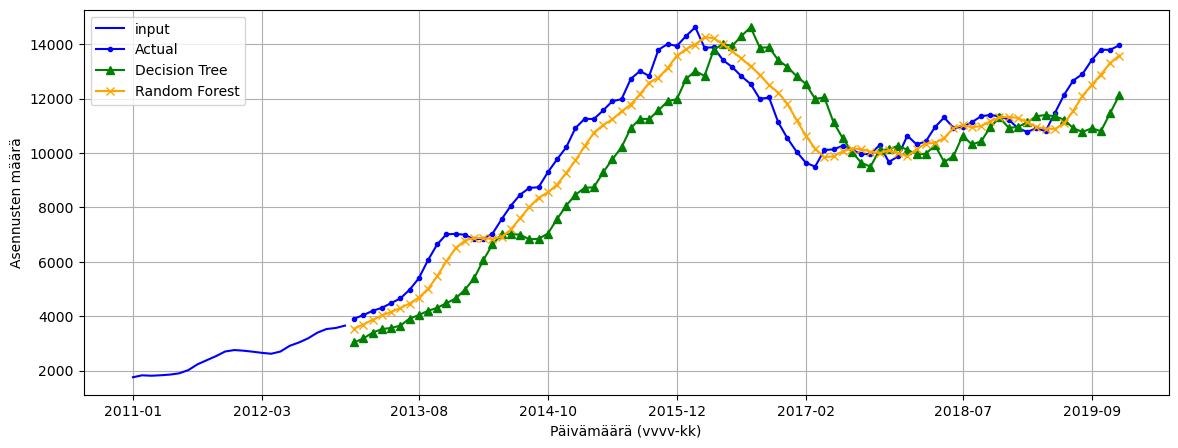

In [12]:
fig, ax = plt.subplots(figsize=(14, 5))

a = input_len
b = input_len + output_len

N = len(seq_df)

def format_date_2(x1, pos=None):
  thisind = np.clip(int(x1 + 0.5), 0, N - 1)
  return df_ML['year-month'].iloc[N - test_size + thisind]

ax.plot(np.arange(0, a, 1), X_test[0], 'b-', label='input')
ax.plot(np.arange(a, b, 1), y_test[0], marker='.', color='blue', label='Actual')
ax.plot(np.arange(a, b, 1), dt_seq_preds[0], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(a, b, 1), rf_seq_preds[0], marker='x', color='orange', label='Random Forest')

locator = mdates.AutoDateLocator(maxticks=8)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date_2)
#fig.autofmt_xdate()
ax.set_xlabel('Päivämäärä (vvvv-kk)')
ax.set_ylabel('Asennusten määrä')
ax.legend()
ax.grid()
plt.show()


Mallit seuraavat jälleen viiveellä toteutunutta asennusmäärää. Tämä voisi viitata siihen, että mallit päätyvät käyttämään opetusdataa näin, koska voivat **JA** se todennäköisesti on kuitenkin tarkin tapa ennustaa asennusmäärää.

In [13]:
res = pd.DataFrame({'Actual': df_ML['count'].tail(84), 'Decision Tree': dt_seq_preds[0], 'Random Forest': rf_seq_preds[0]})
res.tail(10)

Actual  Decision Tree  Random Forest
2019-03  10908.200000        11352.2      10952.248
2019-04  10804.800000        11399.0      10899.858
2019-05  11463.400000        11349.6      10884.366
2019-06  12134.800000        11228.8      11086.156
2019-07  12665.600000        10912.6      11552.812
2019-08  12902.600000        10777.4      12097.116
2019-09  13413.000000        10908.2      12504.640
2019-10  13798.000000        10804.8      12880.512
2019-11  13793.500000        11463.4      13312.000
2019-12  13962.666667        12134.8      13584.982